# Energy Consumption Forecasting with ML in France


**Research Questions**  

To what extent can machine learning models predict daily electricity consumption across French regions, and how do weather and density features improve predictive accuracy?

Which features are most strongly associated with variations in consumption, and how can interpretable ML techniques (e.g., SHAP) be used to understand and communicate these associations?

In [2]:
# IMPORT LIBRARIES
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
#from sklearn.neural_network import MLPRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import sys
#sys.path.append('/users/eleves-b/2024/anahi.reyes-miguel/.local/lib/python3.12/site-packages')
import shap

In [3]:
# Setting the working directory
project_dir = os.getcwd()   

# Path to the Data folder
data_path = os.path.join(project_dir, "data")

# Full path to the CSV
cons_filepath = os.path.join(data_path, "france_energy_meteo_daily.csv")

# Full path to the output folder
figures_path = os.path.join(project_dir, "output")

#Load the dataset and define the target column, drop NA values from the dataset
energy_source_df = pd.read_csv(cons_filepath)
# Display basic info about the dataset 
energy_source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56862 entries, 0 to 56861
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         56862 non-null  object 
 1   region_name  56862 non-null  object 
 2   RR           56862 non-null  float64
 3   ALTI         56862 non-null  float64
 4   PMERM        56862 non-null  float64
 5   INST         56862 non-null  float64
 6   GLOT         56862 non-null  float64
 7   DHUMI40      56862 non-null  float64
 8   NEIGETOTX    56862 non-null  float64
 9   NEIG         56862 non-null  float64
 10  BROU         56862 non-null  float64
 11  ORAG         56853 non-null  float64
 12  GRESIL       47779 non-null  float64
 13  GRELE        47937 non-null  float64
 14  ROSEE        47894 non-null  float64
 15  VERGLAS      55496 non-null  float64
 16  SOLNEIGE     47761 non-null  float64
 17  GELEE        56364 non-null  float64
 18  FUMEE        56862 non-null  float64
 19  BRUM

In [4]:
# 1. Percentage of null values
null_percentage = np.round(100 - energy_source_df.notnull().mean() * 100)

# 2. Percentage of zeros (only for numeric columns)
zero_percentage = (energy_source_df.select_dtypes(include=[np.number]) == 0).mean() * 100
zero_percentage = np.round(zero_percentage)

# 3. Combine both summaries
summary_df = pd.DataFrame({
    "Percentage of Null Values": null_percentage,
    "Percentage of Zeros": zero_percentage
})

# 4. Display full summary
print(summary_df.to_string())

             Percentage of Null Values  Percentage of Zeros
ALTI                               0.0                  0.0
BROU                               0.0                 36.0
BRUME                              0.0                 29.0
Consumption                        9.0                  0.0
DHUMI40                            0.0                 42.0
DRR                                0.0                 24.0
Date                               0.0                  NaN
ECLAIR                            16.0                 76.0
FUMEE                              0.0                100.0
FXY                                0.0                  0.0
GELEE                              1.0                 91.0
GLOT                               0.0                  0.0
GRELE                             16.0                 73.0
GRESIL                            16.0                 82.0
INST                               0.0                  1.0
NEIG                               0.0  

In [5]:
# Ensure the Date column is in a datetime format
energy_source_df["Date"] = pd.to_datetime(energy_source_df["Date"])
#Remove duplicated column
energy_source_df.drop(columns=["Région"], inplace=True)


# Place consumption data in the correct unit (kWh) and calculate the consumption per capita
energy_source_df["Consumption"] = energy_source_df["Consumption"] * 1000
energy_source_df["Consumption_per_capita"] = energy_source_df["Consumption"] / energy_source_df["population"]

# Add the day of the week 
energy_source_df["day_of_week"] = energy_source_df["Date"].dt.dayofweek.astype("category")

# Lag features
energy_source_df["lag_1"] = energy_source_df.groupby("region_name")["Consumption_per_capita"].shift(1)
energy_source_df["lag_7"] = energy_source_df.groupby("region_name")["Consumption_per_capita"].shift(7)

# Rolling average over the past 7 days (can be tuned)
energy_source_df["rolling_7"] = (
    energy_source_df.groupby("region_name")["Consumption_per_capita"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)
# Drop rows with NAs
energy_source_df.dropna(inplace=True)

In [6]:
# 1. Percentage of null values
null_percentage = np.round(100 - energy_source_df.notnull().mean() * 100)

# 2. Percentage of zeros (only for numeric columns)
zero_percentage = (energy_source_df.select_dtypes(include=[np.number]) == 0).mean() * 100
zero_percentage = np.round(zero_percentage)

# 3. Combine both summaries
summary_df = pd.DataFrame({
    "Percentage of Null Values": null_percentage,
    "Percentage of Zeros": zero_percentage
})

# 4. Display full summary
print(summary_df.to_string())

                        Percentage of Null Values  Percentage of Zeros
ALTI                                          0.0                  0.0
BROU                                          0.0                 26.0
BRUME                                         0.0                 25.0
Consumption                                   0.0                  0.0
Consumption_per_capita                        0.0                  0.0
DHUMI40                                       0.0                 42.0
DRR                                           0.0                 22.0
Date                                          0.0                  NaN
ECLAIR                                        0.0                 90.0
FUMEE                                         0.0                 99.0
FXY                                           0.0                  0.0
GELEE                                         0.0                 90.0
GLOT                                          0.0                  0.0
GRELE 

In [7]:
# Display descriptive statistics for the remaining columns
energy_source_df.describe()

,Date,RR,ALTI,PMERM,INST,GLOT,DHUMI40,NEIGETOTX,NEIG,BROU,...,DRR,superf,population,density,Consumption,Workday?,Consumption_per_capita,lag_1,lag_7,rolling_7
count,28783,28783.000000,28783.000000,28783.000000,28783.000000,28783.000000,28783.000000,28783.000000,28783.000000,28783.000000,...,28783.000000,28783.000000,2.878300e+04,28783.000000,2.878300e+04,28783.000000,28783.000000,28783.000000,28783.000000,28783.000000
mean,2017-10-08 21:29:12.659555840,2.487639,324.257290,1017.263979,336.822289,1283.692909,66.111412,2.672802,0.069237,0.277683,...,111.409860,44495.032490,5.553681e+06,200.426786,2.188727e+08,0.970434,40.354952,40.357594,40.365804,40.361512
min,2014-01-08 00:00:00,0.000000,64.802817,975.620000,0.000000,34.222222,0.000000,0.000000,0.000000,0.000000,...,0.000000,12064.688640,2.576252e+06,58.359735,5.959200e+07,0.000000,18.378166,18.378166,18.378166,20.294429
25%,2015-10-24 00:00:00,0.051993,98.730303,1012.787868,123.527530,560.176471,0.000000,0.000000,0.000000,0.000000,...,0.428571,30118.557770,3.330478e+06,78.061664,1.342835e+08,1.000000,33.236839,33.232282,33.237690,33.323600
50%,2017-08-08 00:00:00,0.444124,162.080292,1017.562500,305.625000,1173.941176,1.239130,0.000000,0.000000,0.200000,...,29.285714,32363.434265,5.127840e+06,112.923194,1.968410e+08,1.000000,39.211043,39.214425,39.217451,39.180793
75%,2019-09-14 00:00:00,3.008390,532.272990,1022.438095,526.365278,1938.315315,64.051299,0.676768,0.000000,0.458333,...,161.358974,70795.544145,6.009976e+06,158.830373,2.828530e+08,1.000000,46.782572,46.789581,46.784842,46.835866
max,2021-12-31 00:00:00,83.744086,916.616505,1047.266667,912.222222,3131.843137,930.432099,61.356436,1.000000,1.000000,...,1420.142857,85103.128115,1.231728e+07,1020.936335,6.568900e+08,1.000000,75.535308,75.535308,75.535308,70.671910
std,NaN,4.514243,262.575604,8.393535,241.885085,810.954732,128.845612,7.471832,0.201019,0.276565,...,168.615535,22723.421304,2.722289e+06,273.302946,1.041644e+08,0.169390,9.590935,9.595869,9.595651,9.121212


In [8]:
# Log lin the outcome to Aumentar estabilidad numérica en modelos como SVR o LinearRegression
energy_source_df['LOG_Consumption_per_capita'] = np.log1p(energy_source_df['Consumption_per_capita'])  # computes ln(1 + ingreso)

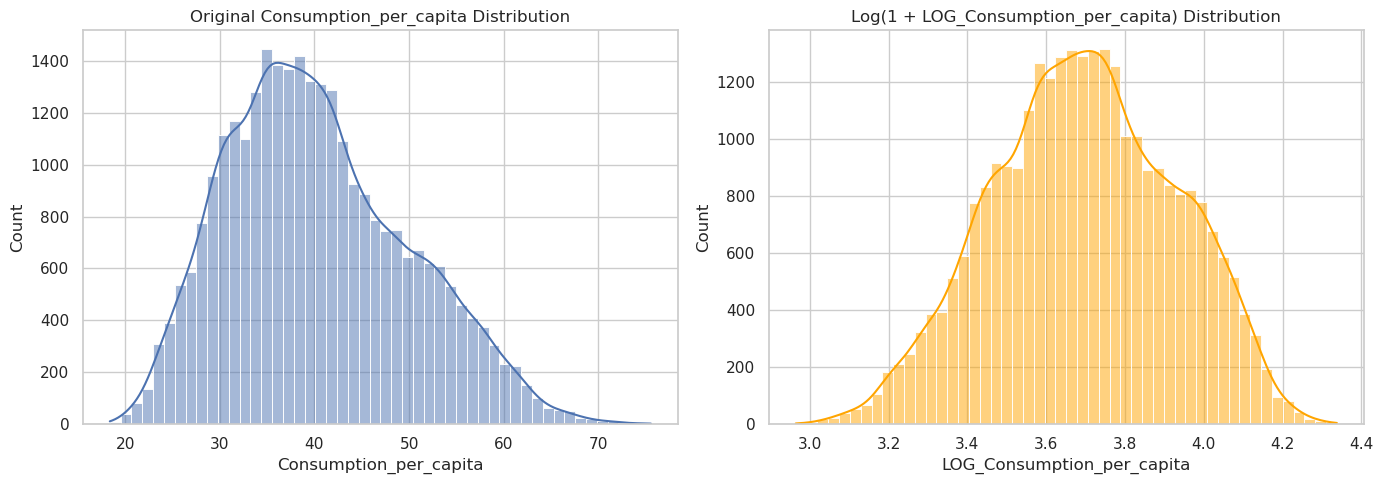

In [9]:
# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Original Income
sns.histplot(energy_source_df['Consumption_per_capita'], bins=50, ax=axs[0], kde=True)
axs[0].set_title("Original Consumption_per_capita Distribution")
axs[0].set_xlabel("Consumption_per_capita")

# Log Income
sns.histplot(energy_source_df['LOG_Consumption_per_capita'], bins=50, ax=axs[1], kde=True, color='orange')
axs[1].set_title("Log(1 + LOG_Consumption_per_capita) Distribution")
axs[1].set_xlabel("LOG_Consumption_per_capita")

plt.tight_layout()
plt.show()

Looking at the distributions:
* Original Consumption_per_capita is already fairly symmetric, bell-shaped, and doesn’t have extreme skewness.
* The log-transformed version is slightly tighter, but not substantially different — and definitely not enough to justify the loss in interpretability for tree-based and deep learning models.

In [10]:
# Target Feature
target = "Consumption_per_capita"

# Temporal / Calendar Features
temporal_variables = [
    "day_of_week",   # 0 = Monday, 6 = Sunday
    "Workday?",      # Binary: 1 if workday, 0 otherwise - It accounts for holidays
]

#  Meteorological Features (climate & weather)
weather_variables = [
    "RR", "ALTI", "PMERM", "INST", "GLOT", "DHUMI40", "NEIGETOTX",
    "BROU", "ORAG", "GRESIL", "GRELE", "ROSEE", "VERGLAS",
    "GELEE", "FUMEE", "BRUME", "ECLAIR", "TX", "TNSOL", "FXY", "DRR"
]

# Regional Features
structural_variables = ["density"]  # Population density by region

# Lag Features
lagged_variables = ["lag_1", "lag_7", "rolling_7"]

# Combine into sets
numeric_features = weather_variables +  temporal_variables  + structural_variables #+ lagged_variables 


### Train-Test Split

To evaluate model performance fairly, we divide our dataset into training and testing subsets. This ensures that we train our models on one portion of the data and test their predictive ability on unseen examples.

* Training Set (90%): Used to train the model
* Testing Set (20%): Held out for evaluating out-of-sample performance

In [11]:
# Define the features (X) and target (y)
X = energy_source_df[numeric_features]
y = energy_source_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (23026, 24)
X_test shape: (5757, 24)
y_train shape: (23026,)
y_test shape: (5757,)


### Data Exploration



In [12]:
# Step 1: Concatenate X_train and y_train 
train_data = pd.concat([X_train, y_train], axis=1)

train_data.describe()

,RR,ALTI,PMERM,INST,GLOT,DHUMI40,NEIGETOTX,BROU,ORAG,GRESIL,...,FUMEE,BRUME,ECLAIR,TX,TNSOL,FXY,DRR,Workday?,density,Consumption_per_capita
count,23026.000000,23026.000000,23026.000000,23026.000000,23026.000000,23026.000000,23026.000000,23026.000000,23026.000000,23026.000000,...,23026.000000,23026.000000,23026.000000,23026.000000,23026.000000,23026.000000,23026.000000,23026.000000,23026.000000,23026.000000
mean,2.498671,324.147584,1017.205391,336.971556,1285.790960,66.557811,2.718070,0.276471,0.122648,0.008843,...,0.000503,0.257282,0.037396,16.787209,6.113948,6.724692,111.693235,0.970338,202.224840,40.306445
std,4.545745,262.630589,8.374459,242.325475,811.716493,129.410697,7.595018,0.275982,0.248345,0.061276,...,0.007491,0.265549,0.139508,7.342565,5.743986,2.218488,169.678215,0.169657,275.668573,9.581463
min,0.000000,64.802817,975.850000,0.000000,35.750000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-5.798061,-13.735897,1.938889,0.000000,0.000000,58.359735,18.378166
25%,0.051282,99.272869,1012.740417,123.800000,561.074405,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.041667,0.000000,11.159238,1.764391,5.146468,0.439236,1.000000,78.061664,33.185879
50%,0.444140,161.807164,1017.494494,305.000000,1178.107143,1.295470,0.000000,0.200000,0.000000,0.000000,...,0.000000,0.166667,0.000000,16.478850,6.073030,6.308309,28.763889,1.000000,112.923194,39.161010
75%,3.013590,532.167180,1022.385714,526.720395,1939.702381,65.007885,0.680417,0.454545,0.111111,0.000000,...,0.000000,0.400000,0.000000,22.212690,10.555417,7.863553,160.638393,1.000000,158.830373,46.732683
max,83.744086,916.616505,1046.980000,912.222222,3131.843137,930.432099,61.356436,1.000000,1.000000,1.000000,...,0.375000,1.000000,1.000000,39.061202,20.911111,20.612766,1420.142857,1.000000,1020.936335,75.535308


In [13]:
# 1) Setup
# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

# 2) Define continuous variables
numeric_features_exp = [target] + numeric_features 

# 4) Force types 
#train data
train_data[numeric_features] = train_data[numeric_features].astype(float)

#test data
train_data[numeric_features] = train_data[numeric_features].astype(float)


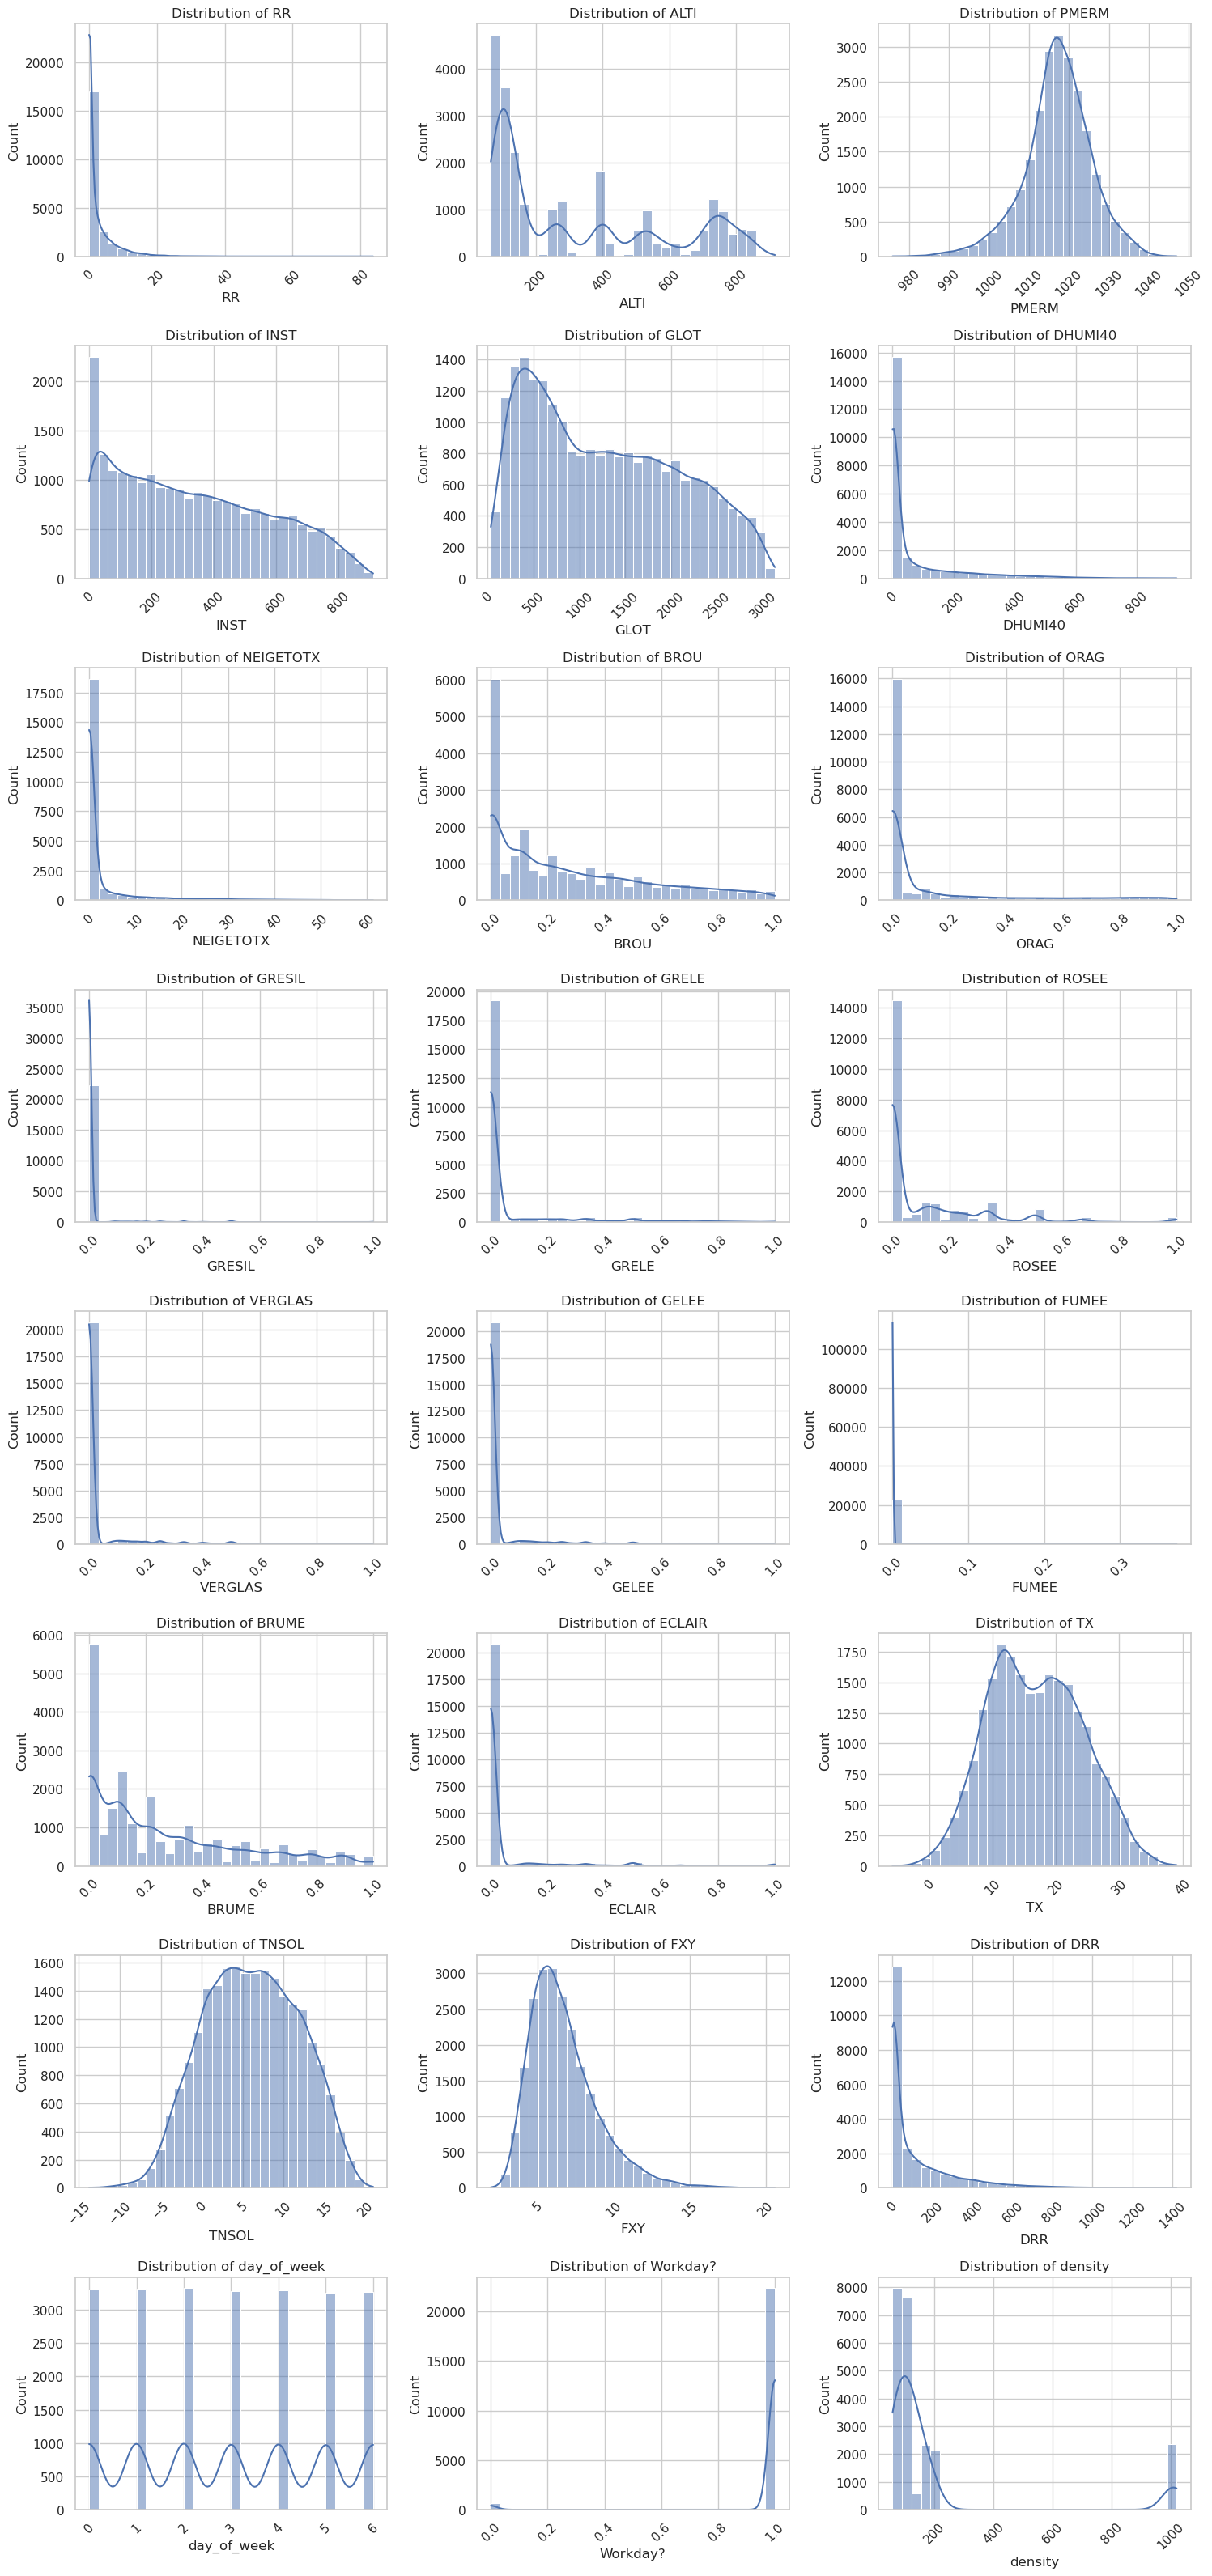

In [14]:
# 3) Plot Continuous Variables (Histograms)
n_cols = 3
n_rows = -(-len(numeric_features) // n_cols)  # Ceiling division

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(data=train_data, x=col, ax=axs[i], kde=True, bins=30)
    axs[i].set_title(f"Distribution of {col}")
    axs[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()

# Save the figure
histogram_path = os.path.join(figures_path, "numeric_features_histograms.png")
plt.savefig(histogram_path, dpi=300)

# Show the plot
plt.show()

In [15]:
# Plot pairplot to visualize relationships between features
#sns.pairplot(train_data[numeric_features_exp])
#plt.suptitle("Pairplot of Features")
#plt.show()

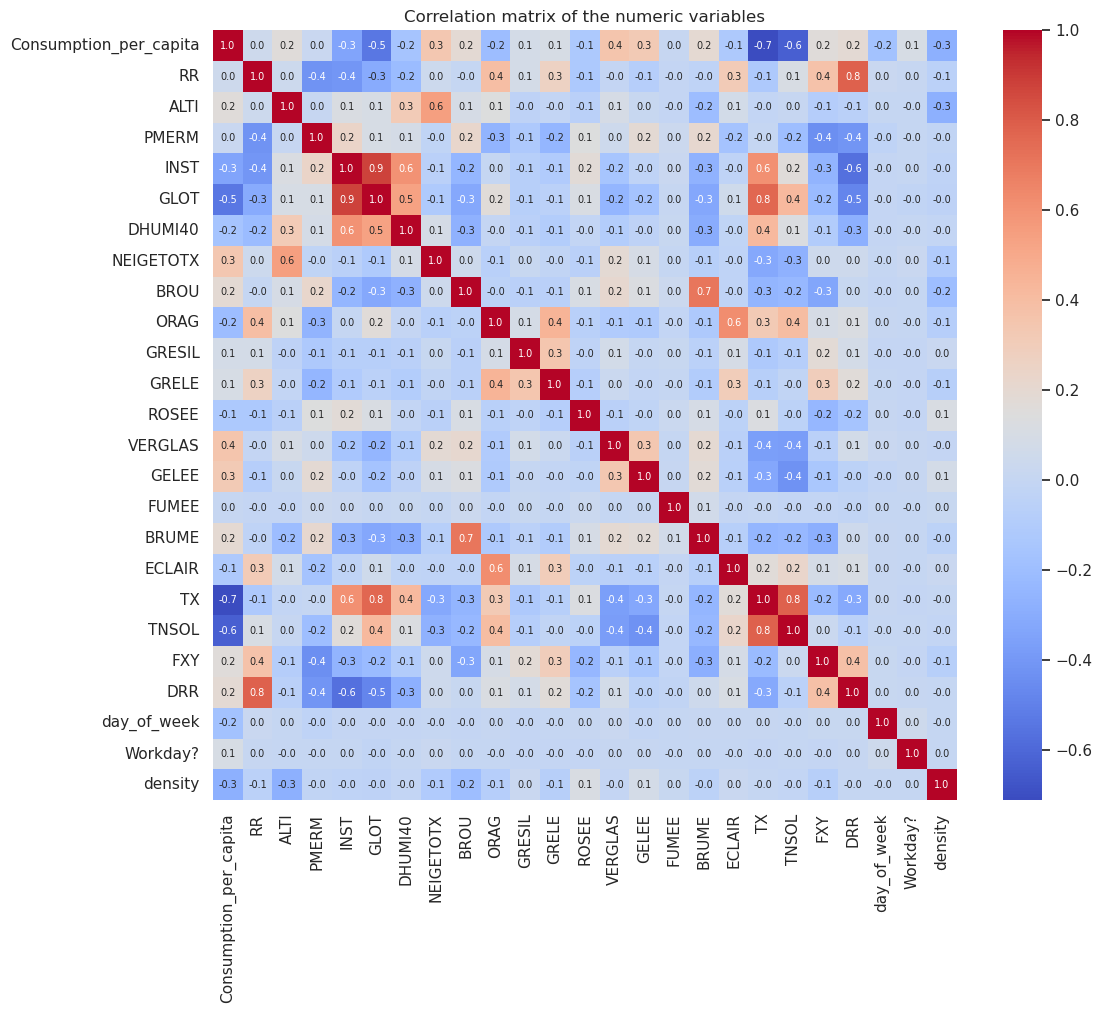

In [16]:
# Calculate the correlation matrix
correlation_matrix = train_data[numeric_features_exp].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f',  annot_kws={'size': 7})
plt.title('Correlation matrix of the numeric variables')


# Save the figure
heatmap_path = os.path.join(figures_path, "correlation_matrix.png")
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



### Preparing the Data

After the exploratory phase, including the inspection of distributions and correlation structures, we now prepare the data for predictive modeling.

This step involves:

* Handling missing values (already addressed)
* Engineering polynomial and interaction terms
* Scaling and encoding features appropriately
* Building preprocessing pipelines for continuous and categorical variables
* This transformation ensures that the data is clean, structured, and model-ready, allowing us to evaluate the importance of education and other variables in predicting income.

In [17]:
"""
Create feature and target variables. Drop categorical variables and highly correlated features
"""
#X = energy_source_df.drop(columns=[target, "Date", 'region_name', 'Région', "Consumption", "population", 'NEIG', 'SOLNEIGE'])
#y = energy_source_df[target]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a K-fold cross-validator instead of TimeSeriesSplit
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# For models that need scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Regression Models: Training, Evaluation, and Interpretation

In [18]:
# Function to show results

"""
This function plots the predictions versus the true values of the test
data for consumption per capita target. All of these graphs are placed
in the report, so a distinguishing title is given to each during input.
The model is also defined in input, to properly differentiate the results
and compare between models.
"""
def plot_predictions(y_true, y_pred, model_name='Model', figure_number="Figure One"):
    plt.figure(figsize=(10, 6))

    plt.scatter(y_true, y_pred, alpha=0.6)

    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    plt.title(r"$\bf{" + figure_number + r"}$ — Actual vs Predicted — " + model_name, fontsize=20)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
#pip install "numpy<2"

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


<>:44: SyntaxWarning: invalid escape sequence '\ '
<>:44: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_1272087/2772187114.py:44: SyntaxWarning: invalid escape sequence '\ '
  plot_predictions(y_test, y_pred_dt, model_name='Decision Tree', figure_number="Figure\ Five")



Decision Tree Regression:
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10}
MAE: 2.230889520025657
RMSE: 3.059516958359478
R-squared (Test): 0.8989844053199961
R-squared (Train): 0.9670176444832533


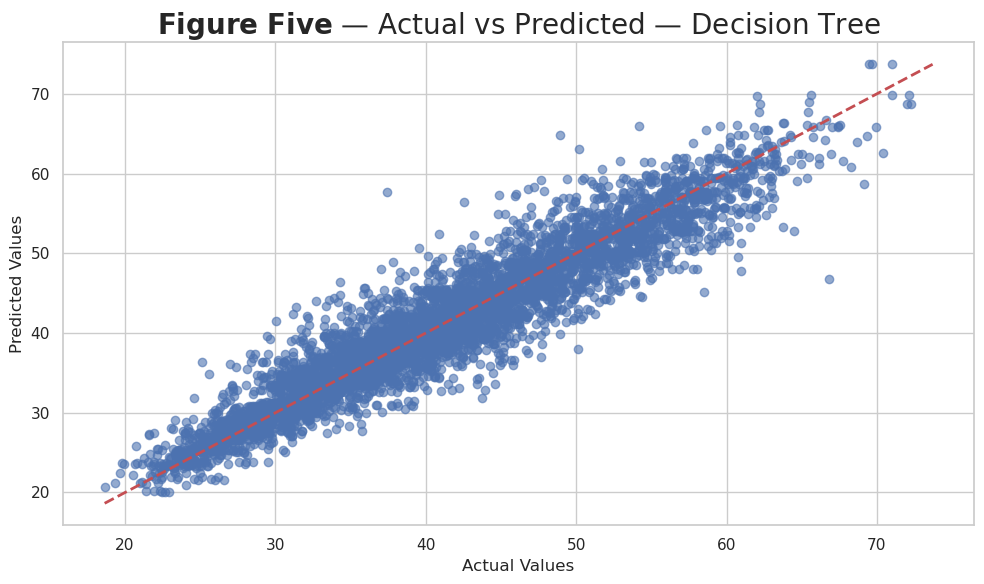

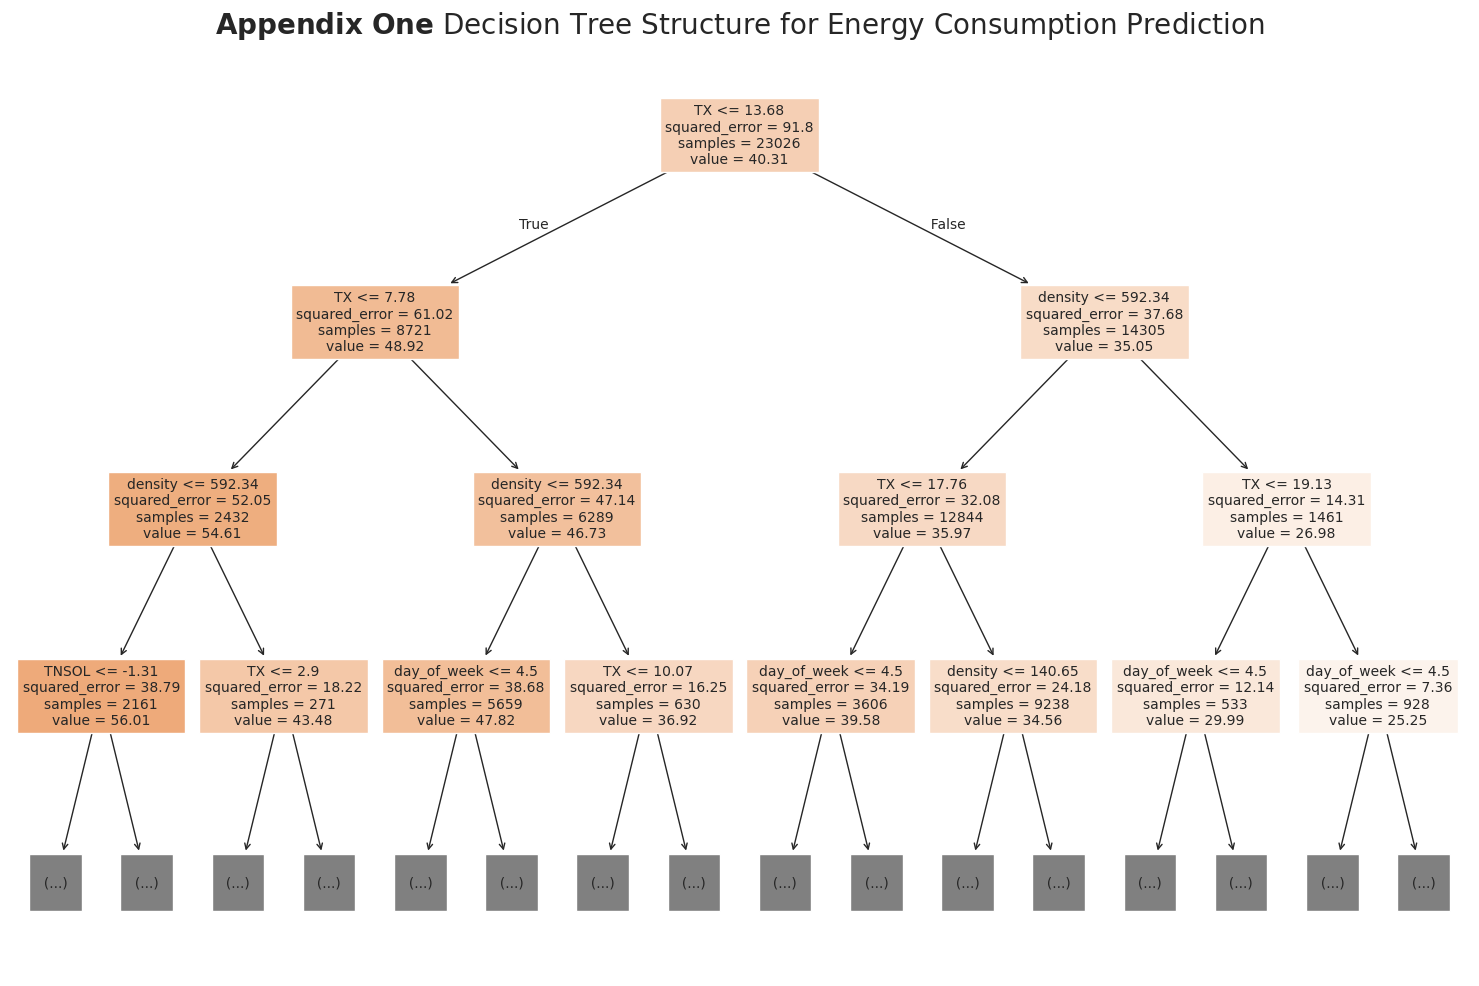

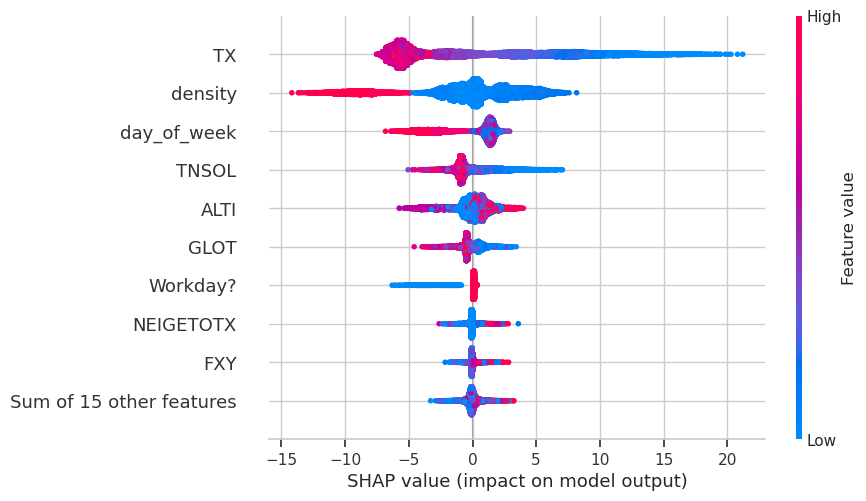

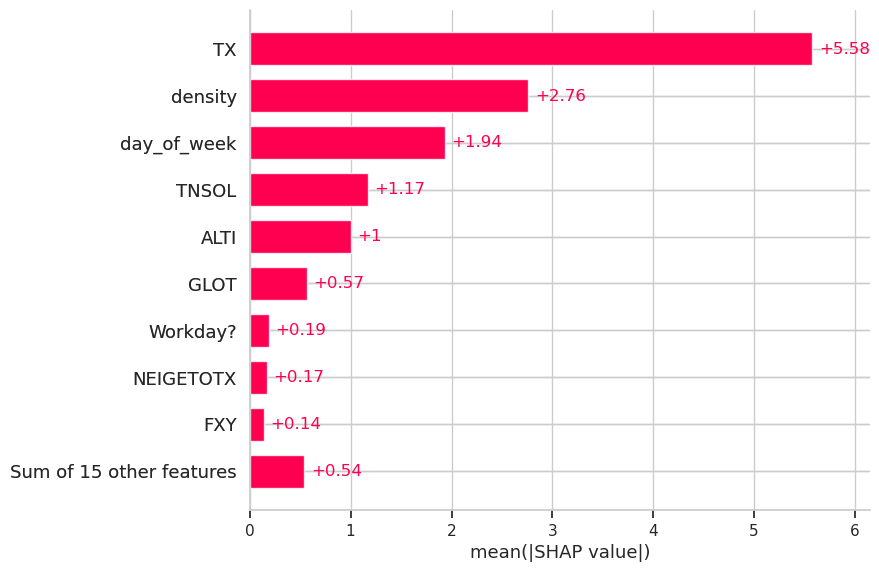

In [39]:
# (2) Decision Tree

# Perform a GridSearchCV that performs cross validation and tuning at the same time. Necessary to
# establish the best performing model for model comparison.
dt_params = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    dt_params,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit training data and cross validate to find best parameters, Generate from Best Estimator in GridSearch, Predict
dt_grid.fit(X_train, y_train)
dt_model = dt_grid.best_estimator_
y_pred_dt = dt_model.predict(X_test)
# Predict on training data
y_pred_train_dt = dt_model.predict(X_train)


# Evaluation Metrics
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt_test = r2_score(y_test, y_pred_dt)
r2_dt_train = r2_score(y_train, y_pred_train_dt)

print("\nDecision Tree Regression:")
print("Best Parameters:", dt_grid.best_params_)
print("MAE:", mae_dt)
print("RMSE:", rmse_dt)
print("R-squared (Test):", r2_dt_test)
print("R-squared (Train):", r2_dt_train)

# Compute performance on training data
y_pred_train = dt_model.predict(X_train)


plot_predictions(y_test, y_pred_dt, model_name='Decision Tree', figure_number="Figure\ Five")

# Print a decision tree to communicate the ease in which a planner could explain the
# prediction from a decision tree. Visual included in the appendix of the report.
plt.figure(figsize=(15, 10))
plot_tree(dt_model,
          feature_names=X.columns,
          filled=True,
          proportion=False,
          precision=2,
          impurity=True,
          max_depth=3,
          fontsize=10,
          node_ids=False,)
plt.title(r"$\bf{Appendix\ One}$ Decision Tree Structure for Energy Consumption Prediction", fontsize=20)
plt.tight_layout(pad=1.0)
plt.show()

# SHAP Explainer
explainer_dt = shap.TreeExplainer(dt_model)
shap_values_dt = explainer_dt(X_train)
shap.plots.beeswarm(shap_values_dt)
shap.plots.bar(shap_values_dt)


<>:39: SyntaxWarning: invalid escape sequence '\ '
<>:39: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_1272087/3171386324.py:39: SyntaxWarning: invalid escape sequence '\ '
  plot_predictions(y_test, y_pred_rf, model_name='Random Forest', figure_number="Figure\ Four")



Random Forest Regression:
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 1.7009773808056003
RMSE: 2.308823868225487
R-squared (Test): 0.942473983403714
R-squared (Train): 0.991874529493048


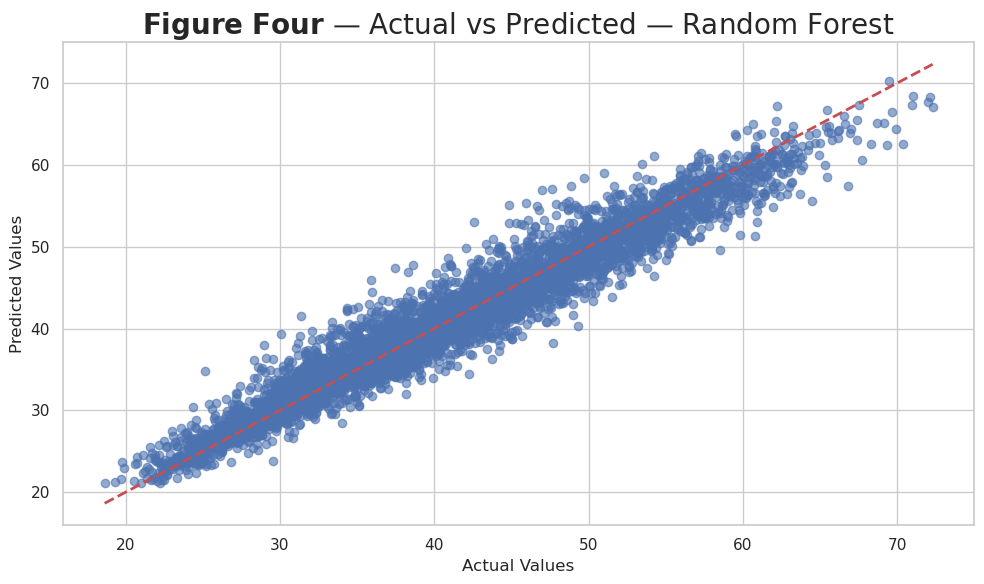

In [ ]:
# (3) Random Forests

# Perform a GridSearchCV that performs cross validation and tuning at the same time. Necessary to
# establish the best performing model for model comparison.
rf_params = {
    'n_estimators': [100, 200], #300
    'max_depth': [10, 30], #None, 50
    'min_samples_split': [2, 5], #10
    'min_samples_leaf': [1, 2] #4
    }

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)


# Fit training data and cross validate to find best parameters, Generate from Best Estimator in GridSearch, , Predict
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_
y_pred_rf = rf_model.predict(X_test)
# Predict on train data
y_pred_rf_train = rf_model.predict(X_train)  

# Evaluation Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf_test = r2_score(y_test, y_pred_rf)
r2_rf_train = r2_score(y_train, y_pred_rf_train) 
print("\nRandom Forest Regression:")
print("Best Parameters:", rf_grid.best_params_)
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R-squared (Test):", r2_rf_test)
print("R-squared (Train):", r2_rf_train)
plot_predictions(y_test, y_pred_rf, model_name='Random Forest', figure_number="Figure\ Four")


# SHAP Explainer
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf(X_train)
shap.plots.beeswarm(shap_values_rf)
shap.plots.bar(shap_values_rf)

<>:37: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_774331/726161229.py:37: SyntaxWarning: invalid escape sequence '\ '
  plot_predictions(y_test, y_pred_svr_linear, model_name='SVR Linear', figure_number="Appendix\ Three")



SVR (Linear):
Best Parameters: {'C': 10.0, 'epsilon': 0.001}
MAE: 1.3310536730927902
RMSE: 1.7350333041463437
R-squared: 0.9675138439285387
R-squared (Train): 0.9661573693878167
R-squared (Test): 0.9675138439285387


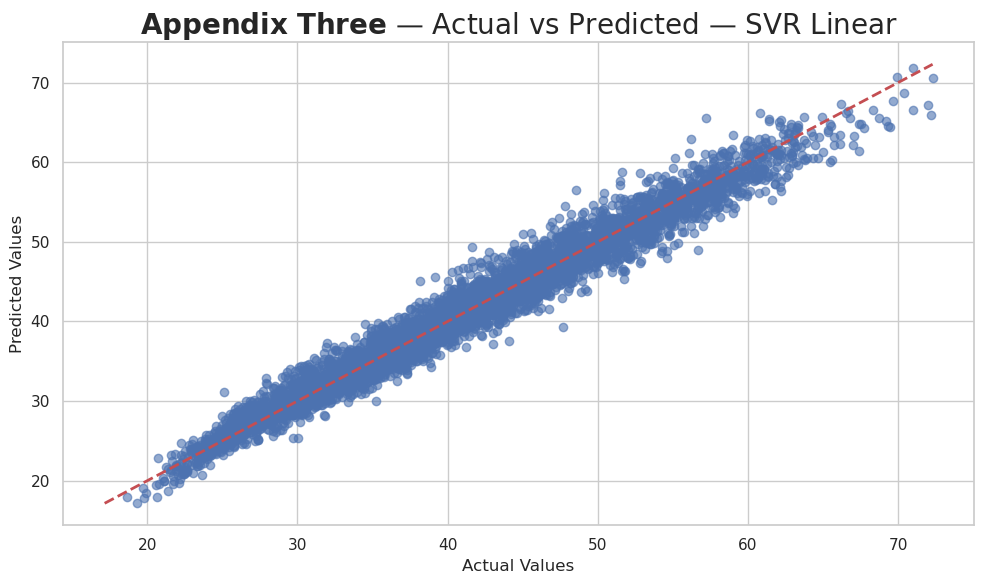

In [ ]:
# (4) Support Vector Machines - Linear Function

# Perform a GridSearchCV that performs cross validation and tuning at the same time. Necessary to
# establish the best performing model for model comparison.
svr_linear_params = {
    'C': [1.0, 10.0], #, 100.0, 1000.0
    'epsilon': [0.001, 0.01] #, 0.1
}

svr_linear_grid = GridSearchCV(
    SVR(kernel='linear'),
    svr_linear_params,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit and cross validate with scaled training, Generate from Best Estimator in GridSearch, Predict to scaled test
svr_linear_grid.fit(X_train_scaled, y_train)
svr_linear_model = svr_linear_grid.best_estimator_
y_pred_svr_linear = svr_linear_model.predict(X_test_scaled)
y_pred_svr_linear_train = svr_linear_model.predict(X_train_scaled)


# Evaluation Metrics
mae_svr_linear = mean_absolute_error(y_test, y_pred_svr_linear)
rmse_svr_linear = np.sqrt(mean_squared_error(y_test, y_pred_svr_linear))
r2_svr_linear_test = r2_score(y_test, y_pred_svr_linear)
r2_svr_linear_train = r2_score(y_train, y_pred_svr_linear_train)
print("\nSVR (Linear):")
print("Best Parameters:", svr_linear_grid.best_params_)
print("MAE:", mae_svr_linear)
print("RMSE:", rmse_svr_linear)
print("R-squared (Test):", r2_svr_linear_test)
print("R-squared (Train):", r2_svr_linear_train)
plot_predictions(y_test, y_pred_svr_linear, model_name='SVR Linear', figure_number="Appendix\ Three")

# SHAP Explainer
explainer_svr_linear_model = shap.KernelExplainer(svr_linear_model)
shap_values_svr_linear_model = explainer_svr_linear_model(X_train_scaled)
shap.plots.beeswarm(shap_values_svr_linear_model)
shap.plots.bar(shap_values_svr_linear_model)

<>:37: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_774331/1834703468.py:37: SyntaxWarning: invalid escape sequence '\ '
  plot_predictions(y_test, y_pred_svr_rbf, model_name='SVR RBF', figure_number="Appendix\ Four")



SVR (RBF):
Best Parameters: {'C': 1.0, 'epsilon': 0.1, 'gamma': 'auto'}
MAE: 1.1397440743510856
RMSE: 1.635701567210966
R-squared: 0.9711270715291543


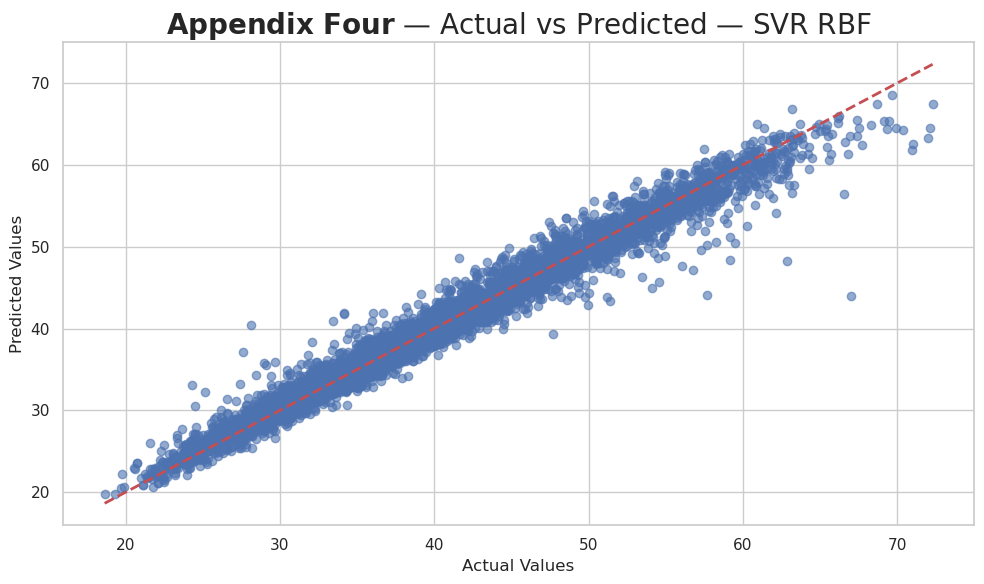

In [ ]:
# (5) Support Vector Machines - Radial Base Function

# Perform a GridSearchCV that performs cross validation and tuning at the same time. Necessary to
# establish the best performing model for model comparison.
svr_rbf_params = {
    'C': [0.1, 1.0],#, 10.0, 100.0
    'gamma': ['auto', 0.1],#'scale', , 0.01
    'epsilon': [0.1, 0.2]#, 0.3
}

svr_rbf_grid = GridSearchCV(
    SVR(kernel='rbf'),
    svr_rbf_params,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit and cross validate with scaled training, Generate from Best Estimator in GridSearch, Predict to scaled test
svr_rbf_grid.fit(X_train_scaled, y_train)
svr_rbf_model = svr_rbf_grid.best_estimator_
y_pred_svr_rbf = svr_rbf_model.predict(X_test_scaled)
y_pred_svr_rbf_train = svr_rbf_model.predict(X_train_scaled)


# Evaluation Metrics
mae_svr_rbf = mean_absolute_error(y_test, y_pred_svr_rbf)
rmse_svr_rbf = np.sqrt(mean_squared_error(y_test, y_pred_svr_rbf))
r2_svr_rbf = r2_score(y_test, y_pred_svr_rbf)
r2_svr_rbf_train = r2_score(y_test, y_pred_svr_rbf_train)

print("\nSVR (RBF):")
print("Best Parameters:", svr_rbf_grid.best_params_)
print("MAE:", mae_svr_rbf)
print("RMSE:", rmse_svr_rbf)
print("R-squared (Test):", r2_svr_rbf)
print("R-squared (Train):", r2_svr_rbf_train)
plot_predictions(y_test, y_pred_svr_rbf, model_name='SVR RBF', figure_number="Appendix\ Four")


# SHAP Explainer
explainer_svr_rbf = shap.KernelExplainer(svr_rbf_model)
shap_values_svr_rbf = explainer_svr_rbf(X_train_scaled)
shap.plots.beeswarm(shap_values_svr_rbf)
shap.plots.bar(shap_values_svr_rbf)